# Cross-validation & Overfitting

In [2]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

# import Iris dataset

In [3]:
iris = sns.load_dataset('iris')
iris.head()
data_iris = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels_iris = torch.zeros(len(data_iris), dtype=torch.long)
labels_iris[iris.species=='versicolor'] = 1
labels_iris[iris.species=='virginica'] = 2


# Create The Model

In [4]:
def model_creation(learning_rate):
  Ann_model = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 3),
  )
  loss_fun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(Ann_model.parameters(), lr = learning_rate)
  return Ann_model, loss_fun, optimizer

## Train Function

In [5]:
def train_fn(model, loss_fun, epoches, train_data, train_label, optimizer, test_set, test_label):
  losses = torch.zeros(epoches)
  Accs_train = torch.zeros(epoches)
  Accs_test = torch.zeros(epoches)
  for e in range(epoches):
    # Forward
    y_hat = model(train_data)
    Accs_train[e] = 100*torch.mean((torch.argmax(y_hat, axis=1) == train_label).float())
    #Compute loss
    loss = loss_fun(y_hat, train_label)
    losses[e] = loss
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_pred = model(test_set)
    Accs_test[e] = 100 * torch.mean((torch.argmax(test_pred, axis=1) == test_label).float())
  return Accs_train, Accs_test

# Manual Separation

### Separate data into train and test

In [ ]:
training_proportion = 0.8
training_samples = int(training_proportion * len(labels_iris))
train_set = np.zeros(len(labels_iris), dtype=bool)

Wrong way of separation

In [ ]:
print("Training Set indecies, True = training data, False = Testing data")
train_set[range(training_samples)] = True
print(train_set)
print("Actual Data")
print(labels_iris)

Training Set indecies, True = training data, False = Testing data
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Actual Data
tensor([

In [ ]:
# We notice that the data we have isn't randomized, and we are chosing 80% of the data
# in a sequential way, this means the training data isn't well destributed, so the model
# won't result in a great preformance, and won't be able to generalize well

# Testing Balance
print('Average of full data:')
print( torch.mean(labels_iris.float()) ) # =1 by definition
print(' ')

print('Average of training data:')
print( torch.mean(labels_iris[train_set].float()) ) # should be 1...
print(' ')

print('Average of test data:')
print( torch.mean(labels_iris[~train_set].float()) ) # should also be 1...

Average of full data:
tensor(1.)
 
Average of training data:
tensor(0.7500)
 
Average of test data:
tensor(2.)


Correct way of separation

In [ ]:
training_items = np.random.choice(range(len(labels_iris)), training_samples, replace=False)
print(f"The training data indecies are: \n {training_items}")

The training data indecies are: 
 [132  84  72  80  28 122  11 148 112  51  42  61  60 135 144 100  15  14
  16  95  92 113  70 134 139  94  87 124 102 118 109  99  75  30  69 117
   6  22  17   2  46 136 114   5  38 142  83  19 131  36  56  85 115 143
  57 106   3   8 120  29  32  76 101  53  26  35  86  59 105 128 129  18
  12  65 149  10  25  40  82 104  43  44  77 127  96  74  66 107 133 121
 108 111  98 130  93   4  20  58  50 126  27  31  68  64  33  34  62  79
 116 145  49   1  39   0  88  55 147  45  78 110]


In [ ]:
train_set.fill(False) # reseting training set to all False, before selecting the new training data
train_set[training_items] = True
print(train_set)
train_label = labels_iris[train_set]
test_label = labels_iris[~train_set]
test_set = data_iris[~train_set, :]
train_set = data_iris[train_set, :]

[ True  True  True  True  True  True  True False  True False  True  True
  True False  True  True  True  True  True  True  True False  True False
 False  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True False  True  True  True  True  True False
 False  True  True  True False  True False  True  True  True  True  True
  True  True  True False  True  True  True False  True  True  True False
  True False  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True False False False  True  True  True  True
  True False  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True False  True False  True  True  True  True  True  True
  True  True  True  True  True False False  True False False  True  True
  True  True False  True  True  True]


Testing Balance

In [ ]:
print('Average of full data:')
print( torch.mean(labels_iris.float()) ) # =1 by definition
print(' ')

print('Average of training data:')
print( torch.mean(train_label.float()) ) # should be approx 1...
print(' ')

print('Average of test data:')
print( torch.mean(test_label.float()) ) # should also be approx 1...

Average of full data:
tensor(1.)
 
Average of training data:
tensor(1.0083)
 
Average of test data:
tensor(0.9667)


### Creating, Training and Testing the Model

In [ ]:
model, loss_fun, optimizer = model_creation(0.01)
# Train model
Accs_train, Accs_test = train_fn(model, loss_fun, 500, train_set, train_label, optimizer, test_set, test_label)
print(f'Train Accuracy = {Accs_train[-1]}')
print(f'Test Accuracy = {Accs_test[-1]}')

Train Accuracy = 97.5
Test Accuracy = 100.0


# Using Sickitlearn to split data and test set

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_iris, labels_iris, train_size=0.8)

In [ ]:
model, loss_fun, optimizer = model_creation(0.01)
# Train model
Accs_train, Accs_test = train_fn(model, loss_fun, 500, x_train, y_train, optimizer, x_test, y_test)
print(f'Train Accuracy = {Accs_train[-1]}')
print(f'Test Accuracy = {Accs_test[-1]}')

Train Accuracy = 98.33333587646484
Test Accuracy = 93.33333587646484


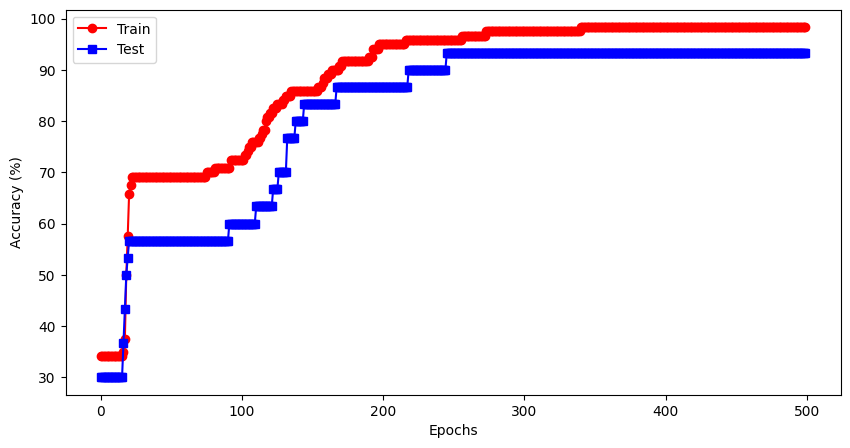

In [ ]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(Accs_train,'ro-')
plt.plot(Accs_test,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

### Experiment

In [ ]:
train_set_size = np.linspace(.2,.95,10)
epoches = 300

Accs_train_all = np.zeros((len(train_set_size),epoches))
Accs_test_all = np.zeros((len(train_set_size),epoches))

for i in range(len(train_set_size)):

  # create a model
  model,loss_fun,optimizer = model_creation(0.01)

  # train the model
  x_train, x_test, y_train, y_test = train_test_split(data_iris, labels_iris, train_size=train_set_size[i])
  train_Acc,test_Acc = train_fn(model, loss_fun, epoches, x_train, y_train, optimizer, x_test, y_test)

  # store the results
  Accs_train_all[i,:] = train_Acc
  Accs_test_all[i,:] = test_Acc

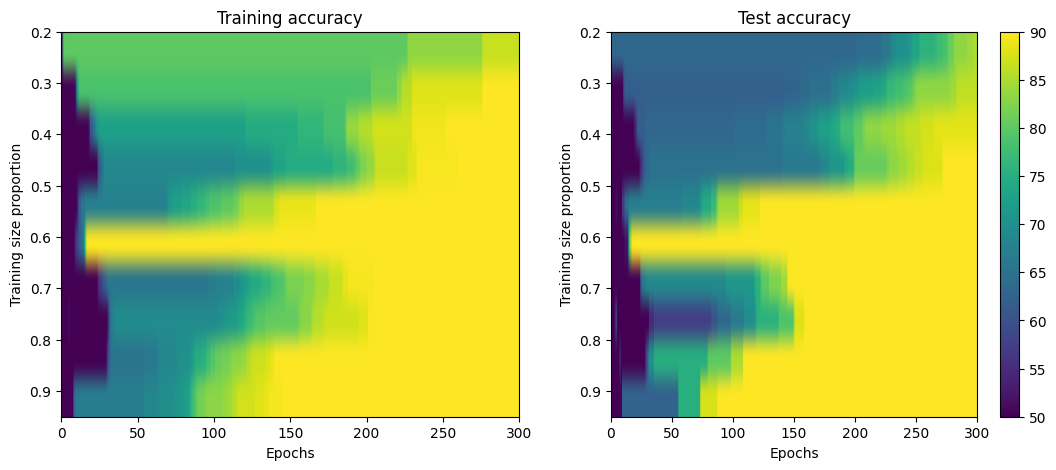

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(Accs_train_all,aspect='auto',
             vmin=50,vmax=90, extent=[0,epoches,train_set_size[-1],train_set_size[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(Accs_test_all,aspect='auto',
             vmin=50,vmax=90, extent=[0,epoches,train_set_size[-1],train_set_size[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()

# DataLoader

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data_iris, labels_iris, train_size=0.8)

train_data_set = TensorDataset(train_data, train_labels)
test_data_set = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data_set, batch_size=12, shuffle=True)
test_loader = DataLoader(test_data_set, batch_size=test_data_set.tensors[0].shape[0])

In [12]:
def train_with_batches():
  train_Acc = []
  test_Acc = []

  for e in range(epoches):
    batch_Acc = []
    for x, y in train_loader:
      y_hat = model(x)
      loss = loss_fun(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_Acc.append(100*torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item())

    train_Acc.append(np.mean(batch_Acc))
    x,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax(model(x),axis=1)
    test_Acc.append(100*torch.mean((predlabels == y).float()).item())

  return train_Acc, test_Acc

In [15]:
model, loss_fun, optimizer = model_creation(learning_rate=0.01)
epoches = 200

In [16]:
trainAcc,testAcc = train_with_batches()

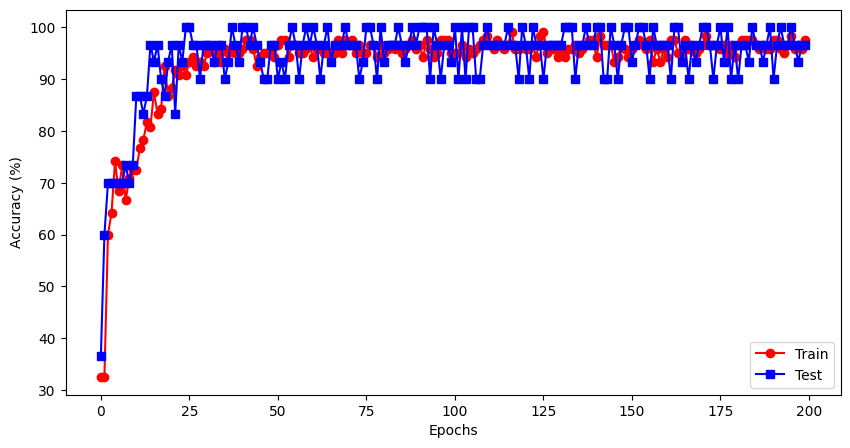

In [18]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()